# Classification of Plant Seedlings using Convolutional Neural Network 

##### Raghavendra Prasad Savada

## Table of Contents

* [Introduction](#intro)
* [Import and Expolore Dataset](#step0)
* [Create a Plain CNN to Classify Seedling Species (to be used as bench mark model)](#step1)
* [Create a CNN by Transfer Learning to Classify Seedling Species](#step2) 
    * [Transfer Learning - InceptionV3](#step3)
    * [Transfer Learning - Xception](#step4)
    * [Transfer Learning - ResNet50](#step5)
* [Test the Final Model Using Images not in the Dataset](#step6)

---
<a id='intro'></a>
## Introduction 

Weeds are one of the most significant cause of crop loss. Reduction in yield and quality due to weed infestations, and cost of controlling weeds have a tremendous economic impact on crop production. Therefore, weed management (restricting the weed population to a minimum threshold) is an important part of crop production. 

Weeds should be controlled as early as possible after crop germination to avoid the adverse effects on crops resulting from competition between weeds and crops for space, sunlight and nutrition. Hence it is important to control the weeds in the seedling stage itself by correctly identifying them. However, at seedling stage there is a high resemblance between many plant species so that distinguishing crop species from weed species is very difficult and labor intensive, and requires high expertise. Correctly identifying weed species is equally difficult because of the resemblance between different species. Different weed species requires different management practices. For instance, herbicide (chemicals that kills weeds) that works on grasses like wheat may not work on broad-leafed plants like pea. Therefore, accurate identification and classification of weed species is of paramount importance in effective weed management. 

This project is aimed at building a Convolutional Neural Network (CNN) to identify three crop and nine weed species at seedling stage (**for more detials see project_report.pdf**).

---
<a id='step0'></a>
## Import and Explore Dataset 

In [1]:
# time it
import time
initial_time = time.time()

In [2]:
# The dataset has been downloaded from the link 
# https://vision.eng.au.dk/plant-seedlings-dataset/ (file name; V1: Nonsegmented single plants (1.7GB)) 
# and stored in "NonsegmentedV1.zip"

#extract zip file
import zipfile
with zipfile.ZipFile("NonsegmentedV1.zip","r") as zip_ref:
    zip_ref.extractall("NonsegmentedV1")


In [3]:
# after zip extraction it is better to rename the folder"Shepherd's Purse" to 
# "Shepherds Purse" with the following code

import os
os.rename('./NonsegmentedV1/Nonsegmented/Shepherd’s Purse/', './NonsegmentedV1/Nonsegmented/Shepherds Purse/')

In [4]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# load seedling dataset and extract features (image files) and targets
data = load_files('./NonsegmentedV1/Nonsegmented/')
seedling_files = np.array(data['filenames'])
seedling_targets = np_utils.to_categorical(np.array(data['target']), 12)

Using TensorFlow backend.


In [5]:
from sklearn.model_selection import train_test_split
# split the dataset into training (70%), validation (15%) and test set(15%)

# split dataset into training and test set

X_train, test_files, y_train, test_targets = train_test_split(seedling_files, seedling_targets, test_size=831, random_state=42)

# split training set into training and validation sets

train_files, valid_files, train_targets, valid_targets = train_test_split(X_train, y_train, test_size=831, random_state=42)

#### Statistics about the dataset

In [6]:
species_names = sorted([item[30:-1] for item in (glob("./NonsegmentedV1/Nonsegmented/*/"))])
species_names
# print statistics about the dataset
print('There are total %d species.' % len(species_names))
print('There are %s total seedling image.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training seedling images.' % len(train_files))
print('There are %d validation seedling images.' % len(valid_files))
print('There are %d test seedling images.'% len(test_files))
print ('Seedling species in this dataset are: ', species_names)

There are total 12 species.
There are 5544 total seedling image.

There are 3882 training seedling images.
There are 831 validation seedling images.
There are 831 test seedling images.
Seedling species in this dataset are:  ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


#### Distribution of different classes (species) in the dataset

In [7]:
import pandas as pd
value_counts = (pd.Series(np.argmax(seedling_targets ,axis=1))).value_counts().sort_index()
df = pd.DataFrame({"Species": species_names, "Class Count": list(value_counts)})
df[["Species", "Class Count"]]

,Species,Class Count
0,Black-grass,310
1,Charlock,452
2,Cleavers,335
3,Common Chickweed,713
4,Common wheat,253
5,Fat Hen,538
6,Loose Silky-bent,766
7,Maize,257
8,Scentless Mayweed,607
9,Shepherds Purse,274


#### Example image from each class

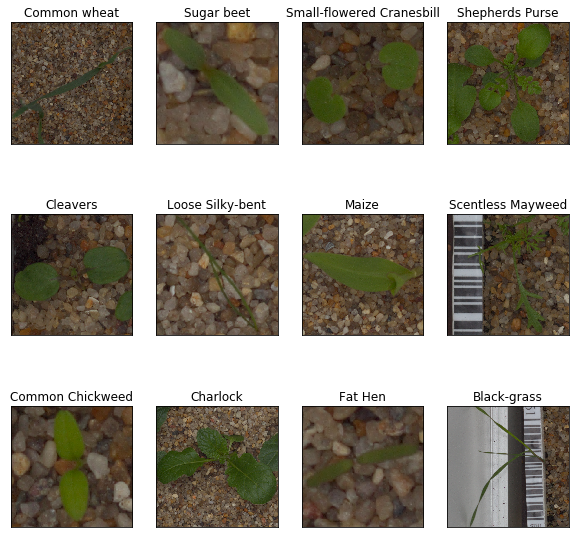

In [8]:
# print one image from each class
import os
import cv2 
import matplotlib.pyplot as plt                        
%matplotlib inline                               

folders = os.listdir("./NonsegmentedV1/Nonsegmented")
files = []
for i in folders:
    files.append("./NonsegmentedV1/Nonsegmented/" + i + "/" +os.listdir("./NonsegmentedV1/Nonsegmented/" + i)[18])

fig = plt.figure(figsize=(10, 10))
for i in range(12):
    title = [item[30:-1] for item in (glob("./NonsegmentedV1/Nonsegmented/*/"))][i]
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    img = cv2.imread(files[i])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(cv_rgb)
    ax.set_title(title)  


---
<a id='step1'></a>
## Create a Plain CNN to Classify Seedling Species (to be used as bench mark model)

In [9]:
# time it
scratch_start = time.time()

#### Preprocess the images

In [10]:
# preprocessing
from keras.preprocessing import image

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

#### Model Architecture

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

### Define architecture.

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(12, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                2408460   
Total params: 2,408,668.0
Trainable params: 2,408,668.0
Non-trainable params: 0.0
_________________________________________________________________


#### Compile the Model

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the Model

In [14]:
from keras.callbacks import ModelCheckpoint   
batch_size = 20
epochs = 25

# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', verbose=1, 
                               save_best_only=True)
model.fit(train_tensors, train_targets,
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)



Train on 3882 samples, validate on 831 samples
Epoch 1/25
3882/3882 [==============================] - 65s - loss: 5.9885 - acc: 0.2666 - val_loss: 1.6271 - val_acc: 0.4561
Epoch 2/25
3882/3882 [==============================] - 65s - loss: 1.3338 - acc: 0.5461 - val_loss: 1.3717 - val_acc: 0.5355
Epoch 3/25
3882/3882 [==============================] - 65s - loss: 0.8768 - acc: 0.7249 - val_loss: 1.2717 - val_acc: 0.6113
Epoch 4/25
3882/3882 [==============================] - 64s - loss: 0.5526 - acc: 0.8490 - val_loss: 1.1004 - val_acc: 0.6366
Epoch 5/25
3882/3882 [==============================] - 65s - loss: 0.3699 - acc: 0.9083 - val_loss: 1.2049 - val_acc: 0.6113
Epoch 6/25
3882/3882 [==============================] - 65s - loss: 0.2517 - acc: 0.9518 - val_loss: 1.1103 - val_acc: 0.6570
Epoch 7/25
3882/3882 [==============================] - 65s - loss: 0.1668 - acc: 0.9699 - val_loss: 1.2343 - val_acc: 0.6438
Epoch 8/25
3882/3882 [==============================] - 65s - loss: 0.1

#### Load the Model with the Best Validation Loss

In [15]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

#### Test the Model

Try out the model on the test dataset of seedling images.

In [16]:
# get index of predicted seedling species for each image in test set
plain_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(plain_predictions)==np.argmax(test_targets, axis=1))/len(plain_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 66.3057%


In [17]:
scratch_end = time.time()
print ("Time (minutes) taken to run plain model: ", (scratch_end - scratch_start)/60)

Time (minutes) taken to run plain model:  28.40153365135193


---
<a id='step2'></a>
## Create a CNN by Transfer Learning to Classify Seedling Species

---
<a id='step3'></a>

## Transfer Learning - InceptionV3

#### Preprocessing of images

In [18]:
# time it
inception_start = time.time()

In [19]:
# preprocessing
from keras.applications import inception_v3

In [20]:
# calculate the image input. 
preprocessed_train_images_inception = inception_v3.preprocess_input(paths_to_tensor(train_files))
preprocessed_valid_images_inception = inception_v3.preprocess_input(paths_to_tensor(valid_files))
preprocessed_test_images_inception = inception_v3.preprocess_input(paths_to_tensor(test_files))

print(preprocessed_train_images_inception.shape)

(3882, 224, 224, 3)


#### Extracting bottleneck features
Here I have used pretrained Keras inception.

In [21]:
from keras.applications.inception_v3 import InceptionV3
# remove the final layers of the network, as they are too specific to the ImageNet database
pretrained_model_inception = InceptionV3(include_top=False)
pretrained_model_inception.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, None, None, 32 864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0                                            
___________________________________________________________________________________________

In [22]:
# Feed the images to the above pretrained_model and collect output
train_inception = pretrained_model_inception.predict(preprocessed_train_images_inception)
valid_inception = pretrained_model_inception.predict(preprocessed_valid_images_inception)
test_inception = pretrained_model_inception.predict(preprocessed_test_images_inception)
np.savez('bottleneck_features/inception_BottleNeckFeatures.npz', train_inception, valid_inception, test_inception)

In [23]:
# load bottleneck features
bottleneck_features_inception = np.load('bottleneck_features/inception_BottleNeckFeatures.npz')

# extract bottleneck features for train, valid and test sets
train_inception = bottleneck_features_inception ['arr_0']
valid_inception = bottleneck_features_inception ['arr_1']
test_inception = bottleneck_features_inception ['arr_2']

#### Create a CNN 


#### Model architecture

In [24]:
### Define architecture.
inception_model = Sequential()
inception_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=train_inception.shape[1:]))
inception_model.add(GlobalAveragePooling2D())
inception_model.add(Dense(12, activation='softmax'))

inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 5, 5, 64)          524352    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                780       
Total params: 525,132.0
Trainable params: 525,132.0
Non-trainable params: 0.0
_________________________________________________________________


#### Compile the model

In [25]:
inception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Train the model

In [26]:
### Train the model.
epochs=25
batch_size=20

start = time.time()
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception.hdf5', 
                               verbose=1, save_best_only=True)

inception_model.fit(train_inception, train_targets, 
          validation_data=(valid_inception, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)
print ('Total time taken: ', time.time()-start)

Train on 3882 samples, validate on 831 samples
Epoch 1/25
3882/3882 [==============================] - 10s - loss: 1.4934 - acc: 0.5072 - val_loss: 1.1012 - val_acc: 0.6258
Epoch 2/25
3882/3882 [==============================] - 10s - loss: 0.7875 - acc: 0.7298 - val_loss: 0.8520 - val_acc: 0.6980
Epoch 3/25
3882/3882 [==============================] - 10s - loss: 0.5685 - acc: 0.8083 - val_loss: 0.7470 - val_acc: 0.7509
Epoch 4/25
3882/3882 [==============================] - 10s - loss: 0.4371 - acc: 0.8475 - val_loss: 0.6925 - val_acc: 0.7617
Epoch 5/25
3882/3882 [==============================] - 11s - loss: 0.3723 - acc: 0.8704 - val_loss: 0.6913 - val_acc: 0.7677
Epoch 6/25
3882/3882 [==============================] - 10s - loss: 0.3103 - acc: 0.8967 - val_loss: 0.7236 - val_acc: 0.7377
Epoch 7/25
3882/3882 [==============================] - 11s - loss: 0.2648 - acc: 0.9119 - val_loss: 0.6471 - val_acc: 0.7798
Epoch 8/25
3882/3882 [==============================] - 10s - loss: 0.2

In [27]:
inception_end = time.time()
print ("Time (minutes) taken to run inception: ", (inception_end - inception_start)/60)

Time (minutes) taken to run inception:  31.675805282592773


---
<a id='step4'></a>

## Transfer Learning - Xception

In [28]:
# time it
xception_start = time.time()

#### Preprocessing of images

In [29]:
from keras.applications.xception import preprocess_input
# calculate the image input. 
preprocessed_train_images = preprocess_input(paths_to_tensor(train_files))
preprocessed_valid_images = preprocess_input(paths_to_tensor(valid_files))
preprocessed_test_images = preprocess_input(paths_to_tensor(test_files))

print(preprocessed_train_images.shape)

(3882, 224, 224, 3)


#### Extracting bottleneck features
Here I have used pretrained Keras Xception.

In [30]:
from keras.applications.xception import Xception
# remove the final layers of the network, as they are too specific to the ImageNet database
pretrained_model = Xception(include_top=False)
pretrained_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, None, None, 32 864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, None, None, 32 128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, None, None, 32 0                                            
___________________________________________________________________________________________

In [31]:
# Feed the images to the above pretrained_model and collect output
train_xception = pretrained_model.predict(preprocessed_train_images)
valid_xception = pretrained_model.predict(preprocessed_valid_images)
test_xception = pretrained_model.predict(preprocessed_test_images)
np.savez('bottleneck_features/xception_BottleNeckFeatures.npz', train_xception, valid_xception, test_xception)

In [32]:
# load the bottleneck features
bottleneck_features = np.load('bottleneck_features/xception_BottleNeckFeatures.npz')

# extract the bottleneck features for train, valid and test images
train_xception = bottleneck_features ['arr_0']
valid_xception = bottleneck_features ['arr_1']
test_xception = bottleneck_features ['arr_2']

#### Create a CNN 


#### Model architecture

In [33]:
### Define architecture.
xception_model = Sequential()
xception_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=train_xception.shape[1:]))
xception_model.add(GlobalAveragePooling2D())
xception_model.add(Dense(12, activation='softmax'))

xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 7, 7, 64)          524352    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
Total params: 525,132.0
Trainable params: 525,132.0
Non-trainable params: 0.0
_________________________________________________________________


#### Compile the model



In [34]:
xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Train the model

In [35]:
### Train the model.

epochs=25
batch_size=20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception.hdf5', 
                               verbose=1, save_best_only=True)

xception_model.fit(train_xception, train_targets, 
          validation_data=(valid_xception, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)


Train on 3882 samples, validate on 831 samples
Epoch 1/25
3882/3882 [==============================] - 19s - loss: 1.1746 - acc: 0.6072 - val_loss: 0.7978 - val_acc: 0.7292
Epoch 2/25
3882/3882 [==============================] - 18s - loss: 0.5975 - acc: 0.8001 - val_loss: 0.6420 - val_acc: 0.7954
Epoch 3/25
3882/3882 [==============================] - 18s - loss: 0.4331 - acc: 0.8594 - val_loss: 0.5747 - val_acc: 0.8026
Epoch 4/25
3882/3882 [==============================] - 18s - loss: 0.3342 - acc: 0.8887 - val_loss: 0.5152 - val_acc: 0.8135
Epoch 5/25
3882/3882 [==============================] - 18s - loss: 0.2557 - acc: 0.9217 - val_loss: 0.5525 - val_acc: 0.8135
Epoch 6/25
3882/3882 [==============================] - 18s - loss: 0.2213 - acc: 0.9315 - val_loss: 0.7385 - val_acc: 0.7557
Epoch 7/25
3882/3882 [==============================] - 19s - loss: 0.1860 - acc: 0.9433 - val_loss: 0.5129 - val_acc: 0.8243
Epoch 8/25
3882/3882 [==============================] - 18s - loss: 0.1

In [36]:
xception_end = time.time()
print ("Time (minutes) taken to run xception: ", (xception_end - xception_start)/60)

Time (minutes) taken to run xception:  62.38819041252136


---
<a id='step5'></a>

## Transfer Learning - ResNet50

#### Preprocessing of images

In [37]:
# time it
resnet50_start = time.time()

In [38]:
# preprocessing
from keras.applications import resnet50

In [39]:
# calculate the image input. 
preprocessed_train_images_resnet50 = resnet50.preprocess_input(paths_to_tensor(train_files))
preprocessed_valid_images_resnet50 = resnet50.preprocess_input(paths_to_tensor(valid_files))
preprocessed_test_images_resnet50 = resnet50.preprocess_input(paths_to_tensor(test_files))

print(preprocessed_train_images_resnet50.shape)

(3882, 224, 224, 3)


#### Extracting bottleneck features
Here I have used pretrained Keras ResNet50.

In [40]:
from keras.applications.resnet50 import ResNet50
#remove the final layers of the network, as they are too specific to the ImageNet database
pretrained_model_resnet50 = ResNet50(include_top=False)
pretrained_model_resnet50.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256                                          
___________________________________________________________________________________________

In [41]:
# Feed the images to the above pretrained_model and collect output
train_resnet50 = pretrained_model_resnet50.predict(preprocessed_train_images_resnet50)
valid_resnet50 = pretrained_model_resnet50.predict(preprocessed_valid_images_resnet50)
test_resnet50 = pretrained_model_resnet50.predict(preprocessed_test_images_resnet50)
np.savez('bottleneck_features/resnet50_BottleNeckFeatures.npz', train_resnet50, valid_resnet50, test_resnet50)

In [42]:
# load the bottle neck features
bottleneck_features_resnet50 = np.load('bottleneck_features/resnet50_BottleNeckFeatures.npz')

# extract bottleneck features for train, valid and test sets

train_resnet50 = bottleneck_features_resnet50 ['arr_0']
valid_resnet50 = bottleneck_features_resnet50 ['arr_1']
test_resnet50 = bottleneck_features_resnet50 ['arr_2']

#### Create a CNN 


#### Model architecture

In [43]:
### Define architecture.
resnet50_model = Sequential()
resnet50_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=train_resnet50.shape[1:]))
resnet50_model.add(GlobalAveragePooling2D())
resnet50_model.add(Dense(12, activation='softmax'))

resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 1, 1, 64)          524352    
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                780       
Total params: 525,132.0
Trainable params: 525,132.0
Non-trainable params: 0.0
_________________________________________________________________


#### Compile the model

In [44]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Train the model

In [45]:
### Train the model.
epochs=25
batch_size=20

start = time.time()
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet50.hdf5', 
                               verbose=1, save_best_only=True)

resnet50_model.fit(train_resnet50, train_targets, 
          validation_data=(valid_resnet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)
print ('Total time taken: ', time.time()-start)

Train on 3882 samples, validate on 831 samples
Epoch 1/25
3882/3882 [==============================] - 2s - loss: 0.9517 - acc: 0.6919 - val_loss: 0.5221 - val_acc: 0.8099
Epoch 2/25
3882/3882 [==============================] - 1s - loss: 0.4069 - acc: 0.8745 - val_loss: 0.4624 - val_acc: 0.8255
Epoch 3/25
3882/3882 [==============================] - 1s - loss: 0.2848 - acc: 0.9083 - val_loss: 0.4132 - val_acc: 0.8448
Epoch 4/25
3882/3882 [==============================] - 1s - loss: 0.2084 - acc: 0.9325 - val_loss: 0.3341 - val_acc: 0.8748
Epoch 5/25
3882/3882 [==============================] - 1s - loss: 0.1577 - acc: 0.9521 - val_loss: 0.4276 - val_acc: 0.8748
Epoch 6/25
3882/3882 [==============================] - 1s - loss: 0.1320 - acc: 0.9603 - val_loss: 0.3416 - val_acc: 0.8761
Epoch 7/25
3882/3882 [==============================] - 1s - loss: 0.1184 - acc: 0.9660 - val_loss: 0.3171 - val_acc: 0.8941
Epoch 8/25
3882/3882 [==============================] - 1s - loss: 0.0893 - ac

### Choose Final Model

Considering accuracy on validation set, I have chosen the model built on ResNet50 as the final model.

Note: I have tried many different architectures with Xception, InceptionV3 and ResNet50. I also tried different batch size and optimizers like rmsprop. Only final architecture and parameters that yielded the best results are shown above for Xception, InceptionV3 and ResNet50.

##### Load the ResNet50 Model with the Best Validation Loss

In [46]:
### Load the model weights with the best validation loss.
resnet50_model.load_weights('saved_models/weights.best.resnet50.hdf5')

#### Test the Model
Try out the model on the test dataset of seedling images. 

In [47]:
# Calculate classification accuracy on the test dataset.
# get index of predicted species for each image in test set
resnet50_predictions = [np.argmax(resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(resnet50_predictions)==np.argmax(test_targets, axis=1))/len(resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 92.0578%


In [48]:
resnet50_end = time.time()
print ("Time (minutes) taken to run resnet50: ", (resnet50_end - resnet50_start)/60)

Time (minutes) taken to run resnet50:  47.80246034860611


#### Performance of the final model on three crop species

In [49]:
# create confusion matrix of predicted species vs true species in the test set
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(np.argmax(test_targets ,axis=1), resnet50_predictions)

#### Confusion matrix

In [50]:
pd.DataFrame(cf, columns = species_names, index = species_names)

,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet
Black-grass,21,0,0,0,6,0,15,1,0,0,0,0
Charlock,0,67,0,0,0,0,0,0,0,0,1,0
Cleavers,0,0,57,0,0,0,0,0,0,0,0,0
Common Chickweed,0,0,0,95,0,0,1,0,4,0,1,0
Common wheat,1,0,0,0,37,0,0,0,0,1,0,1
Fat Hen,1,0,0,1,0,70,1,0,0,1,0,3
Loose Silky-bent,4,0,0,0,3,0,117,0,0,0,0,0
Maize,0,1,0,0,1,0,0,31,1,0,0,0
Scentless Mayweed,0,0,0,0,0,0,1,0,74,0,0,1
Shepherds Purse,0,0,0,1,0,0,0,0,5,37,2,0


In [51]:
# estimate recall for each of the three crop species
maize_index = species_names.index('Maize')
maize_as = (cf[maize_index][maize_index]/sum(cf[maize_index]))*100

sugarbeet_index = species_names.index('Sugar beet')
sugarbeet_as = (cf[sugarbeet_index][sugarbeet_index]/sum(cf[sugarbeet_index]))*100

wheat_index = species_names.index('Common wheat')
wheat_as = (cf[wheat_index][wheat_index]/sum(cf[wheat_index]))*100

print ("The final model predicted Maize with a recall of %.2f%%" % maize_as)
print ("The final model predicted Sugar beet with a recall of %.2f%%" % sugarbeet_as)
print ("The final model predicted Common Wheat with a recall of %.2f%%" % wheat_as)


The final model predicted Maize with a recall of 91.18%
The final model predicted Sugar beet with a recall of 91.04%
The final model predicted Common Wheat with a recall of 92.50%


#### Model recall on three crop species
The final model predicted **Maize** with a recall of **91.18%**. It predicted **Sugar beet** with a recall of **91.04%** and **Common Wheat** with a recall of **92.50%**.


---
<a id='step6'></a>

## Test the Final Model Using Images not in the Dataset

Download some images of the seedlings of the species in this dataset from the internet and see how the final model perform on these images. 

In [52]:
def resnet50_predict_species(img_path):
    # extract bottleneck features
    bottleneck_feature = pretrained_model_resnet50.predict(resnet50.preprocess_input(path_to_tensor(img_path)))
    # obtain predicted vector
    predicted_vector = resnet50_model.predict(bottleneck_feature)
    # return seedling species that is predicted by the model
    return species_names[np.argmax(predicted_vector)]

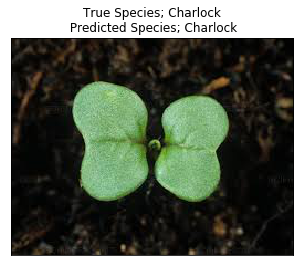

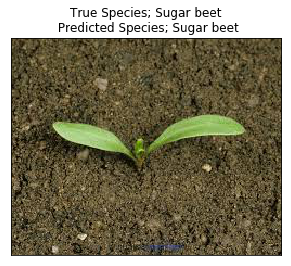

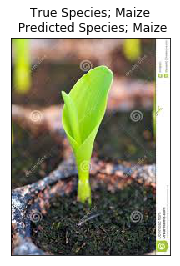

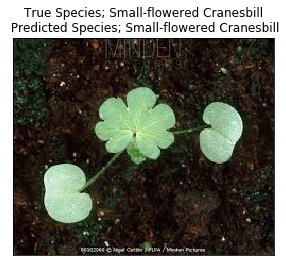

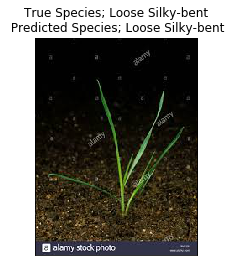

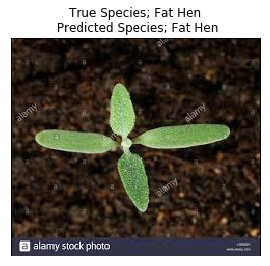

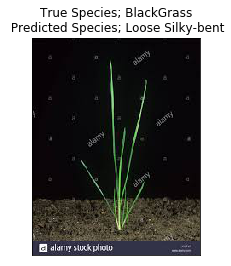

In [58]:
True_image = []
predicted = []
# import image files to be predicted
img_files = glob('./images_to_be_predicted/*')
for file in img_files:
    true_image = file[25:-6]
    predicted_species = resnet50_predict_species(file)
    title = ("True Species; {}\n Predicted Species; {}".format(true_image, predicted_species))
    True_image.append(true_image)
    predicted.append(predicted_species)
    # process the image
    img = cv2.imread(file)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print the image
    plt.imshow(cv_rgb)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()
    print()

    


#### Predicted species vs true species in the downloaded image

In [59]:
print ("True image vs prediction")
df = pd.DataFrame({"True Image": True_image, "Prediction": predicted})
df[['True Image', 'Prediction']]

True image vs prediction


,True Image,Prediction
0,Charlock,Charlock
1,Sugar beet,Sugar beet
2,Maize,Maize
3,Small-flowered Cranesbill,Small-flowered Cranesbill
4,Loose Silky-bent,Loose Silky-bent
5,Fat Hen,Fat Hen
6,BlackGrass,Loose Silky-bent


In [60]:
end_time = time.time()

print ("Time (minutes) taken to run this entire notebook: ", (end_time- initial_time)/60)

Time (minutes) taken to run this entire notebook:  183.7784945289294
